In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

#from itertools import cycle

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import pickle

In [2]:
# separate main drum components
files_snare = glob('data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike/*.wav')
files_toms_rack = glob('data/MDLib2.2/MDLib2.2/Sorted/Rack Tom/Strike/*.wav')
files_toms_floor = glob('data/MDLib2.2/MDLib2.2/Sorted/Floor Tom/Strike/*.wav')
files_kick = glob('data/MDLib2.2/MDLib2.2/Sorted/Kick/*/*/*.wav')

files_hihat = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/HiHat/*/*.wav')
files_ride = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Ride/Tip/*.wav')
files_crash = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Bright Crash/*/*.wav')
files_dark_crash = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash/*/*.wav')

# combine bright and dark crash files into list of crashes
for i in files_dark_crash:
    files_crash.append(i)

In [3]:
# Used to load audio files w/ librosa and extract y values and sample rate
def load_file(file):
    
    # reset lists
    y_values = []
    sample_rates = []
    
    # loop through file list
    for i in file:
        
        # pull y-values and sample rate from each file
        y, sr = librosa.load(i)
        
        # add values to respective lists
        y_values.append(y)
        sample_rates.append(sr)
        
    return y_values, sample_rates

In [4]:
# duration of audio file
def get_duration(file):
    dur = librosa.get_duration(filename=file)
    return dur

In [5]:
# trim duration of audio file based on decibel threshold
def trim_audio(y, db=25):
    y_trimmed, ind = librosa.effects.trim(y, top_db=db)
    dur_trimmed = librosa.get_duration(y=y_trimmed)
    return(dur_trimmed)

In [6]:
# trim y values (basically, the duration again) based on decibel threshold
def trim_y(y, db=25):
    y_trimmed, ind = librosa.effects.trim(y, top_db=db)
    return(y_trimmed)

### Dataframe Assembly

In [7]:
# Create SNARE dataframe
y, sr = load_file(files_snare)

snare = pd.DataFrame({
    "file_name": files_snare,
    "ins": 'snare',
    "sr": sr,
    "y": y
})
snare['y_trimmed'] = snare['y'].map(trim_y)
snare['length'] = snare['file_name'].map(get_duration)
snare['length_trimmed'] = snare['y'].map(trim_audio)



# Create RACK TOMS dataframe
y, sr = load_file(files_toms_rack)

toms_rack = pd.DataFrame({
    "file_name": files_toms_rack,
    "ins": 'rack_tom',
    "sr": sr,
    "y": y
})
# Add trimmed columns
toms_rack['y_trimmed'] = toms_rack['y'].map(trim_y)
toms_rack['length'] = toms_rack['file_name'].map(get_duration)
toms_rack['length_trimmed'] = toms_rack['y'].map(trim_audio)



# Create FLOOR TOMS dataframe
y, sr = load_file(files_toms_floor)

toms_floor = pd.DataFrame({
    "file_name": files_toms_floor,
    "ins": 'floor_tom',
    "sr": sr,
    "y": y
})
# Add trimmed columns
toms_floor['y_trimmed'] = toms_floor['y'].map(trim_y)
toms_floor['length'] = toms_floor['file_name'].map(get_duration)
toms_floor['length_trimmed'] = toms_floor['y'].map(trim_audio)



# Create KICK dataframe
y, sr = load_file(files_kick)

kick = pd.DataFrame({
    "file_name": files_kick,
    "ins": 'kick',
    "sr": sr,
    "y": y
})
# Add trimmed columns
kick['y_trimmed'] = kick['y'].map(trim_y)
kick['length'] = kick['file_name'].map(get_duration)
kick['length_trimmed'] = kick['y'].map(trim_audio)



# Create HIHAT dataframe
y, sr = load_file(files_hihat)

hihat = pd.DataFrame({
    "file_name": files_hihat,
    "ins": 'hihat',
    "sr": sr,
    "y": y
})
# Add trimmed columns
hihat['y_trimmed'] = hihat['y'].map(trim_y)
hihat['length'] = hihat['file_name'].map(get_duration)
hihat['length_trimmed'] = hihat['y'].map(trim_audio)



# Create RIDE CYMBAL dataframe
y, sr = load_file(files_ride)

ride = pd.DataFrame({
    "file_name": files_ride,
    "ins": 'ride',
    "sr": sr,
    "y": y
})
# Add trimmed columns
ride['y_trimmed'] = ride['y'].map(trim_y)
ride['length'] = ride['file_name'].map(get_duration)
ride['length_trimmed'] = ride['y'].map(trim_audio)



# Create CRASH CYMBAL dataframe
y, sr = load_file(files_crash)

crash = pd.DataFrame({
    "file_name": files_crash,
    "ins": 'crash',
    "sr": sr,
    "y": y
})
# Add trimmed columns
crash['y_trimmed'] = crash['y'].map(trim_y)
crash['length'] = crash['file_name'].map(get_duration)
crash['length_trimmed'] = crash['y'].map(trim_audio)



# COMBINE dataframes
df_list = [snare, toms_rack, toms_floor, kick, hihat, ride, crash]

df = pd.concat(df_list)

## Feature Engineering

In [8]:
def get_summary_stats(y):
    
    # creates one column df to perform descriptive stats on
    col = pd.DataFrame(y).T
    
    # get descriptive stats
    ds = col.describe(include='all')
    
    # assign variables for each stat
    mean = ds.loc['mean']
    std = ds.loc['std']
    mini = ds.loc['min']
    q1 = ds.loc['25%']
    medi = ds.loc['50%']
    q3 = ds.loc['75%']
    maxi = ds.loc['max']
    
    return(mean, std, mini, q1, medi, q3, maxi)

In [9]:
# root mean square values for each frame of audio
def calc_rms(y):
    rms = librosa.feature.rms(y=y, frame_length=2048)
    return(rms)

In [10]:
# spectral centroid: center of spectral mass
def calc_spec_centroid(y):
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=22050)
    return(spec_cent)

In [11]:
# bandwidth when max energy at one half
def calc_spec_bandwidth(y):
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=22050)
    return(spec_bandwidth)

In [12]:
# measures frequency at which a percentage
# (85% is default) of total energy is below threshold
def calc_spec_rolloff(y):
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=22050)
    return(spec_rolloff)

In [13]:
# rate at which a signal crosses the x axis in a given frame
def calc_zero_cross(y):
    zero_cross_rate = librosa.feature.zero_crossing_rate(y=y, frame_length=2048)
    return(zero_cross_rate)

#### Calculating New Features

In [14]:
# calc root mean square value for each frame of audio sample

df['rms'] = df['y_trimmed'].map(calc_rms)

x = [get_summary_stats(i) for i in df['rms']]

df['rms_mean'] = [i[0][0] for i in x]
df['rms_std'] = [i[1][0] for i in x]
df['rms_min'] = [i[2][0] for i in x]
df['rms_25%'] = [i[3][0] for i in x]
df['rms_median'] = [i[4][0] for i in x]
df['rms_75%'] = [i[5][0] for i in x]
df['rms_max'] = [i[6][0] for i in x]
df['rms_IQR'] = abs(df['rms_25%'] - df['rms_75%'])

In [15]:
# how low or how high sound is - takes avg of pitch

df['spec_centroid'] = df['y_trimmed'].map(calc_spec_centroid)

x = [get_summary_stats(i) for i in df['spec_centroid']]

df['spec_centroid_mean'] = [i[0][0] for i in x]
df['spec_centroid_std'] = [i[1][0] for i in x]
df['spec_centroid_min'] = [i[2][0] for i in x]
df['spec_centroid_25%'] = [i[3][0] for i in x]
df['spec_centroid_median'] = [i[4][0] for i in x]
df['spec_centroid_75%'] = [i[5][0] for i in x]
df['spec_centroid_max'] = [i[6][0] for i in x]
df['spec_centroid_IQR'] = abs(df['spec_centroid_25%'] - df['spec_centroid_75%'])

In [16]:
# bandwidth at one half peak maximum energy

df['spec_bandwidth'] = df['y_trimmed'].map(calc_spec_bandwidth)

x = [get_summary_stats(i) for i in df['spec_bandwidth']]

df['spec_bandwidth_mean'] = [i[0][0] for i in x]
df['spec_bandwidth_std'] = [i[1][0] for i in x]
df['spec_bandwidth_min'] = [i[2][0] for i in x]
df['spec_bandwidth_25%'] = [i[3][0] for i in x]
df['spec_bandwidth_median'] = [i[4][0] for i in x]
df['spec_bandwidth_75%'] = [i[5][0] for i in x]
df['spec_bandwidth_max'] = [i[6][0] for i in x]
df['spec_bandwidth_IQR'] = abs(df['spec_bandwidth_25%'] - df['spec_bandwidth_75%'])

In [17]:
# measures frequency at which some percentage
# (usually 85%) of total energy is contained

df['spec_rolloff'] = df['y_trimmed'].map(calc_spec_rolloff)

x = [get_summary_stats(i) for i in df['spec_rolloff']]

df['spec_rolloff_mean'] = [i[0][0] for i in x]
df['spec_rolloff_std'] = [i[1][0] for i in x]
df['spec_rolloff_min'] = [i[2][0] for i in x]
df['spec_rolloff_25%'] = [i[3][0] for i in x]
df['spec_rolloff_median'] = [i[4][0] for i in x]
df['spec_rolloff_75%'] = [i[5][0] for i in x]
df['spec_rolloff_max'] = [i[6][0] for i in x]
df['spec_rolloff_IQR'] = abs(df['spec_rolloff_25%'] - df['spec_rolloff_75%'])

In [18]:
# compute zero crossing rate of an audio time series

df['zcr'] = df['y_trimmed'].map(calc_zero_cross)

x = [get_summary_stats(i) for i in df['zcr']]

df['zcr_mean'] = [i[0][0] for i in x]
df['zcr_std'] = [i[1][0] for i in x]
df['zcr_min'] = [i[2][0] for i in x]
df['zcr_25%'] = [i[3][0] for i in x]
df['zcr_median'] = [i[4][0] for i in x]
df['zcr_75%'] = [i[5][0] for i in x]
df['zcr_max'] = [i[6][0] for i in x]
df['zcr_IQR'] = abs(df['zcr_25%'] - df['zcr_75%'])

## ML Testing

In [19]:
# list of all column names that won't be used in modeling
cols_to_drop = ['ins', 'file_name', 'sr', 'y', 'y_trimmed',
                'length','rms', 'spec_centroid',
                'spec_bandwidth', 'spec_rolloff', 'zcr']

# assign training and target set
X = df.drop(columns=cols_to_drop)
y = df['ins']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

## Decision Tree (Baseline Model)

In [20]:
# Instantiate the model
dt_clf = DecisionTreeClassifier(random_state=42)

# fit the model to the data
dt_clf.fit(X_train, y_train)

# predict the instrument played in X_test
results = dt_clf.predict(X_test)

# score predictions versus actual y_test
acc = balanced_accuracy_score(y_test, results)
acc

0.9409248836863633

In [21]:
print(classification_report(y_test, results))

              precision    recall  f1-score   support

       crash       0.86      0.89      0.88       154
   floor_tom       1.00      0.98      0.99        98
       hihat       0.96      0.96      0.96       296
        kick       1.00      0.99      1.00       128
    rack_tom       0.98      1.00      0.99        91
        ride       0.82      0.77      0.79        64
       snare       0.99      1.00      1.00       169

    accuracy                           0.95      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.95      0.95      0.95      1000



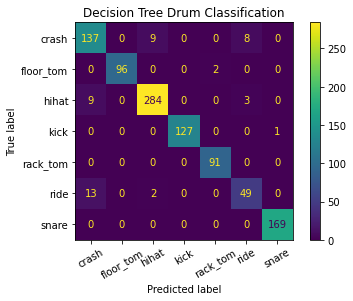

In [22]:
# create confusion matrix to see where the type 1&2 errors occurred
plot_confusion_matrix(dt_clf, X_test, y_test, xticks_rotation=30)
plt.title('Decision Tree Drum Classification')
plt.show()

## Random Forest (Intermediate Model)

In [23]:
# assign estimators used in random forest
estimators = 300

# instantiate the model
rf = RandomForestClassifier(n_estimators=estimators,
                                random_state=42)

# fit the model to the data
rf.fit(X_train, y_train)

# predict the instrument played in X_test
results = rf.predict(X_test)

# score predictions versus actual y_test
acc = balanced_accuracy_score(y_test, results)

print(f'Acc Score with {estimators} estimators: {acc}')

Acc Score with 300 estimators: 0.9780604633920961


In [24]:
print(classification_report(y_test, results))

              precision    recall  f1-score   support

       crash       0.91      0.97      0.94       154
   floor_tom       1.00      0.99      0.99        98
       hihat       0.99      0.98      0.98       296
        kick       1.00      1.00      1.00       128
    rack_tom       1.00      1.00      1.00        91
        ride       1.00      0.91      0.95        64
       snare       1.00      1.00      1.00       169

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



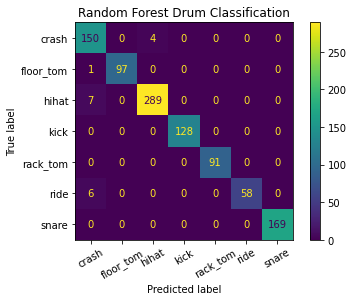

In [25]:
# create confusion matrix to see where the type 1&2 errors occurred
plot_confusion_matrix(rf, X_test, y_test, xticks_rotation=30)
plt.title('Random Forest Drum Classification')
plt.show()

predicted crash column shows 14 false positives (1 floor_tom, 7 hihat, 6 ride)

true value crash row shows 4 false negatives (4 hihat)

In [26]:
# List the features sorted in descending order by feature importance
by_features = sorted(zip(rf.feature_importances_, X.columns), reverse=True)
for feature_rank in by_features:
    print(f"{feature_rank[1]}: ({feature_rank[0]})")

length_trimmed: (0.07614462868849893)
spec_centroid_max: (0.06561412325765824)
zcr_max: (0.06081793516064646)
spec_rolloff_max: (0.056961834660130224)
zcr_25%: (0.05377607133448421)
zcr_median: (0.0436797422641571)
zcr_mean: (0.04330760394301005)
spec_bandwidth_min: (0.034488019621853466)
spec_rolloff_min: (0.033824214569712165)
spec_bandwidth_25%: (0.03375729914866037)
zcr_min: (0.03374950894486848)
spec_centroid_min: (0.02948124879365023)
zcr_75%: (0.028819543891429492)
spec_bandwidth_mean: (0.027650088534723317)
spec_bandwidth_max: (0.02626606620722219)
spec_rolloff_25%: (0.02547403453441452)
spec_rolloff_median: (0.022106275862835804)
spec_bandwidth_75%: (0.020860228995536585)
spec_bandwidth_median: (0.019996141898707975)
spec_rolloff_mean: (0.019619793019365006)
spec_centroid_75%: (0.018432809394468723)
spec_centroid_25%: (0.017293502023025088)
spec_centroid_median: (0.01590314689680439)
spec_centroid_mean: (0.015569465488428209)
spec_rolloff_75%: (0.015231861399914082)
spec_centr

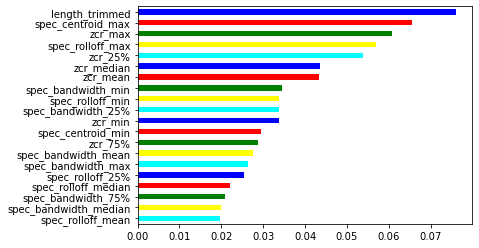

In [27]:
# Chart important features in optimized Random Forest
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',
                                   color=['blue', 'red', 'green', 'yellow', 'cyan']).invert_yaxis()

## XGBoost (Final Model)

In [28]:
# instantiate the model
xg_clf = xgb.XGBClassifier(booster='gbtree', n_estimators=300,
                          learning_rate=0.3, max_depth=6,
                           random_state=42)

# fit the model
xg_clf.fit(X_train, y_train)

# predict what instrument was played in X_test
pred = xg_clf.predict(X_test)

# score predicted results versus actual y_test values
score = balanced_accuracy_score(y_test, pred)
score

0.9839350183737938

In [29]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       crash       0.95      0.98      0.96       154
   floor_tom       1.00      0.99      0.99        98
       hihat       0.99      0.98      0.98       296
        kick       1.00      1.00      1.00       128
    rack_tom       1.00      1.00      1.00        91
        ride       0.95      0.94      0.94        64
       snare       1.00      1.00      1.00       169

    accuracy                           0.99      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000



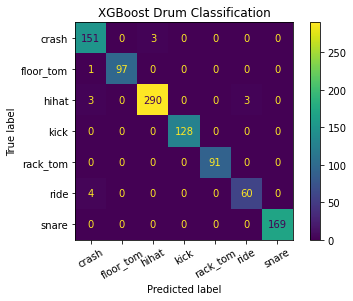

In [30]:
# create confusion matrix to see where the type 1&2 errors occurred
plot_confusion_matrix(xg_clf, X_test, y_test, xticks_rotation=30)
plt.title('XGBoost Drum Classification')
plt.show()

Crash FP = 1 + 3 + 0 + 0 + 4 + 0 = 9

Crash FN = 0 + 3 + 0 + 0 + 0 + 0 = 3

## Exporting Model

In [31]:
# saves the xgboost model to model folder
pickle.dump(xg_clf, open('Model/xgb_model.pkl', 'wb'))